In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:

def create_frequency_grid(size):
    """Create a 2D frequency grid centered at (size//2, size//2)."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    return X, Y

def create_notch_points(uk, vk, size):
    """Create array of notch points (symmetric pairs)."""
    points = np.array([
        [uk, vk],      # Original point
        [-uk, -vk],    # Symmetric point
        [uk, -vk],     # Additional symmetric point for 2D
        [-uk, vk]      # Additional symmetric point for 2D
    ])
    center = size // 2
    return points + center

def distance_from_points(X, Y, points):
    """Calculate minimum distance from each point in X,Y to any notch point."""
    D = np.inf * np.ones_like(X)
    for point in points:
        Dk = np.sqrt((X - point[0])**2 + (Y - point[1])**2)
        D = np.minimum(D, Dk)
    return D

def ideal_notch_reject(X, Y, uk, vk, D0):
    """Ideal notch reject filter.
    X, Y: Frequency coordinates
    uk, vk: Notch center coordinates
    D0: Notch width
    """
    # Calculate squared distances from notch center and its symmetric point
    Dk1_sq = (X - uk)**2 + (Y - vk)**2
    Dk2_sq = (X + uk)**2 + (Y + vk)**2

    # Create filter
    H = np.ones_like(X)
    H[Dk1_sq <= D0**2] = 0  # Notch at (uk, vk)
    H[Dk2_sq <= D0**2] = 0  # Symmetric notch at (-uk, -vk)
    return H

def butterworth_notch_reject(X, Y, uk, vk, D0, n):
    """Butterworth notch reject filter.
    X, Y: Frequency coordinates
    uk, vk: Notch center coordinates
    D0: Cutoff distance
    n: Order of the filter
    """
    # Calculate distances from notch centers
    Dk1_sq = (X - uk)**2 + (Y - vk)**2
    Dk2_sq = (X + uk)**2 + (Y + vk)**2

    # Create filter components for each notch
    H1 = 1 / (1 + (D0**2 / (Dk1_sq + 1e-10))**n)
    H2 = 1 / (1 + (D0**2 / (Dk2_sq + 1e-10))**n)

    # Combine filters
    H = H1 * H2
    return H

def gaussian_notch_reject(X, Y, uk, vk, D0):
    """Gaussian notch reject filter.
    X, Y: Frequency coordinates
    uk, vk: Notch center coordinates
    D0: Standard deviation
    """
    # Calculate squared distances from notch centers
    Dk1_sq = (X - uk)**2 + (Y - vk)**2
    Dk2_sq = (X + uk)**2 + (Y + vk)**2

    # Create filter components for each notch
    H1 = 1 - np.exp(-Dk1_sq / (2 * D0**2))
    H2 = 1 - np.exp(-Dk2_sq / (2 * D0**2))

    # Combine filters
    H = H1 * H2
    return H

def create_test_images(size=256):
    """Create test images with periodic noise patterns."""
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Base image
    base = np.exp(-(X**2 + Y**2)/20)

    # Create periodic noise with specific frequencies
    noise1 = 0.5 * np.sin(2*np.pi*X*0.1)  # Vertical stripes
    noise2 = 0.5 * np.sin(2*np.pi*Y*0.1)  # Horizontal stripes
    noise3 = 0.5 * np.sin(2*np.pi*(X+Y)*0.1)  # Diagonal stripes

    image1 = base + noise1
    image2 = base + noise2
    image3 = base + noise1 + noise2 + noise3

    return {
        'Vertical Noise': image1,
        'Horizontal Noise': image2,
        'Multiple Noise': image3
    }

def plot_comprehensive_view(uk, vk, D0, n_butterworth, filter_type='All'):
    """Create comprehensive visualization of notch filters."""
    size = 100
    x = np.arange(-size//2, size//2)
    y = np.arange(-size//2, size//2)
    X, Y = np.meshgrid(x, y)

    filters = {}
    if filter_type in ['All', 'Ideal']:
        filters['Ideal'] = ideal_notch_reject(X, Y, uk, vk, D0)
    if filter_type in ['All', 'Butterworth']:
        filters['Butterworth'] = butterworth_notch_reject(X, Y, uk, vk, D0, n_butterworth)
    if filter_type in ['All', 'Gaussian']:
        filters['Gaussian'] = gaussian_notch_reject(X, Y, uk, vk, D0)

    n_filters = len(filters)
    fig = plt.figure(figsize=(5*n_filters, 12))

    for idx, (name, response) in enumerate(filters.items()):
        # 1D Profile through notch point
        ax1 = fig.add_subplot(3, n_filters, idx + 1)
        center = size // 2
        ax1.plot(range(size), response[center, :], linewidth=2)
        ax1.axvline(x=center+uk, color='r', linestyle='--', alpha=0.5, label='Notch')
        ax1.axvline(x=center-uk, color='r', linestyle='--', alpha=0.5)
        ax1.set_title(f'{name} Notch Filter 1D Profile')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Response')
        ax1.grid(True)
        ax1.legend()

        # 3D Surface
        ax2 = fig.add_subplot(3, n_filters, idx + 1 + n_filters, projection='3d')
        surf = ax2.plot_surface(X, Y, response, cmap='viridis')
        ax2.set_title(f'{name} Notch Filter 3D Surface')
        ax2.set_xlabel('u')
        ax2.set_ylabel('v')
        ax2.set_zlabel('H(u,v)')

        # Magnitude Image
        ax3 = fig.add_subplot(3, n_filters, idx + 1 + 2*n_filters)
        im = ax3.imshow(response, cmap='viridis')
        ax3.set_title(f'{name} Notch Filter Magnitude')
        plt.colorbar(im, ax=ax3)

        # Mark notch points
        ax3.plot(size//2 + uk, size//2 + vk, 'rx', markersize=10)
        ax3.plot(size//2 - uk, size//2 - vk, 'rx', markersize=10)

    plt.tight_layout()
    plt.show()

def apply_notch_filter(img, uk, vk, D0, n_butterworth):
    """Apply notch filters to an image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)

    rows, cols = img.shape
    x = np.arange(-cols//2, cols//2)
    y = np.arange(-rows//2, rows//2)
    X, Y = np.meshgrid(x, y)

    # Create filters
    filters = {
        'Ideal': ideal_notch_reject(X, Y, uk, vk, D0),
        'Butterworth': butterworth_notch_reject(X, Y, uk, vk, D0, n_butterworth),
        'Gaussian': gaussian_notch_reject(X, Y, uk, vk, D0)
    }

    # Apply filters
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    filtered_images = {}
    filtered_spectrums = {}

    for name, filt in filters.items():
        filtered_shift = fshift * filt
        filtered_images[name] = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))
        filtered_spectrums[name] = np.log(np.abs(filtered_shift) + 1)

    # Plotting
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))

    # Original image and spectrum
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(magnitude_spectrum, cmap='gray')
    axes[1,0].set_title('Original Spectrum')
    axes[2,0].remove()

    # Mark notch points on original spectrum
    axes[1,0].plot(cols//2 + uk, rows//2 + vk, 'rx', markersize=10)
    axes[1,0].plot(cols//2 - uk, rows//2 - vk, 'rx', markersize=10)

    # Filtered images and spectrums
    for idx, (name, filtered) in enumerate(filtered_images.items(), 1):
        # Filter response
        axes[0,idx].imshow(filters[name], cmap='viridis')
        axes[0,idx].set_title(f'{name} Filter')
        axes[0,idx].plot(cols//2 + uk, rows//2 + vk, 'rx', markersize=10)
        axes[0,idx].plot(cols//2 - uk, rows//2 - vk, 'rx', markersize=10)

        # Filtered image
        axes[1,idx].imshow(filtered_images[name], cmap='gray')
        axes[1,idx].set_title(f'{name} Filtered')

        # Filtered spectrum
        axes[2,idx].imshow(filtered_spectrums[name], cmap='gray')
        axes[2,idx].set_title(f'{name} Spectrum')
        axes[2,idx].plot(cols//2 + uk, rows//2 + vk, 'rx', markersize=10)
        axes[2,idx].plot(cols//2 - uk, rows//2 - vk, 'rx', markersize=10)

    for ax in axes.flat:
        if ax is not None:
            ax.axis('off')

    plt.tight_layout()
    plt.show()



In [3]:
# Create interactive widgets
interact(
    plot_comprehensive_view,
    uk=widgets.IntSlider(
        value=10,
        min=-50,
        max=50,
        step=1,
        description='uk:',
        continuous_update=False
    ),
    vk=widgets.IntSlider(
        value=20,
        min=-50,
        max=50,
        step=1,
        description='vk:',
        continuous_update=False
    ),
    D0=widgets.IntSlider(
        value=5,
        min=1,
        max=20,
        step=1,
        description='D₀:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    ),
    filter_type=widgets.Dropdown(
        options=['All', 'Ideal', 'Butterworth', 'Gaussian'],
        description='Filter:',
        value='All'
    )
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='uk:', max=50, min=-50), IntSli…

<function __main__.plot_comprehensive_view(uk, vk, D0, n_butterworth, filter_type='All')>

## Test image with added noise in the Frequency Domain

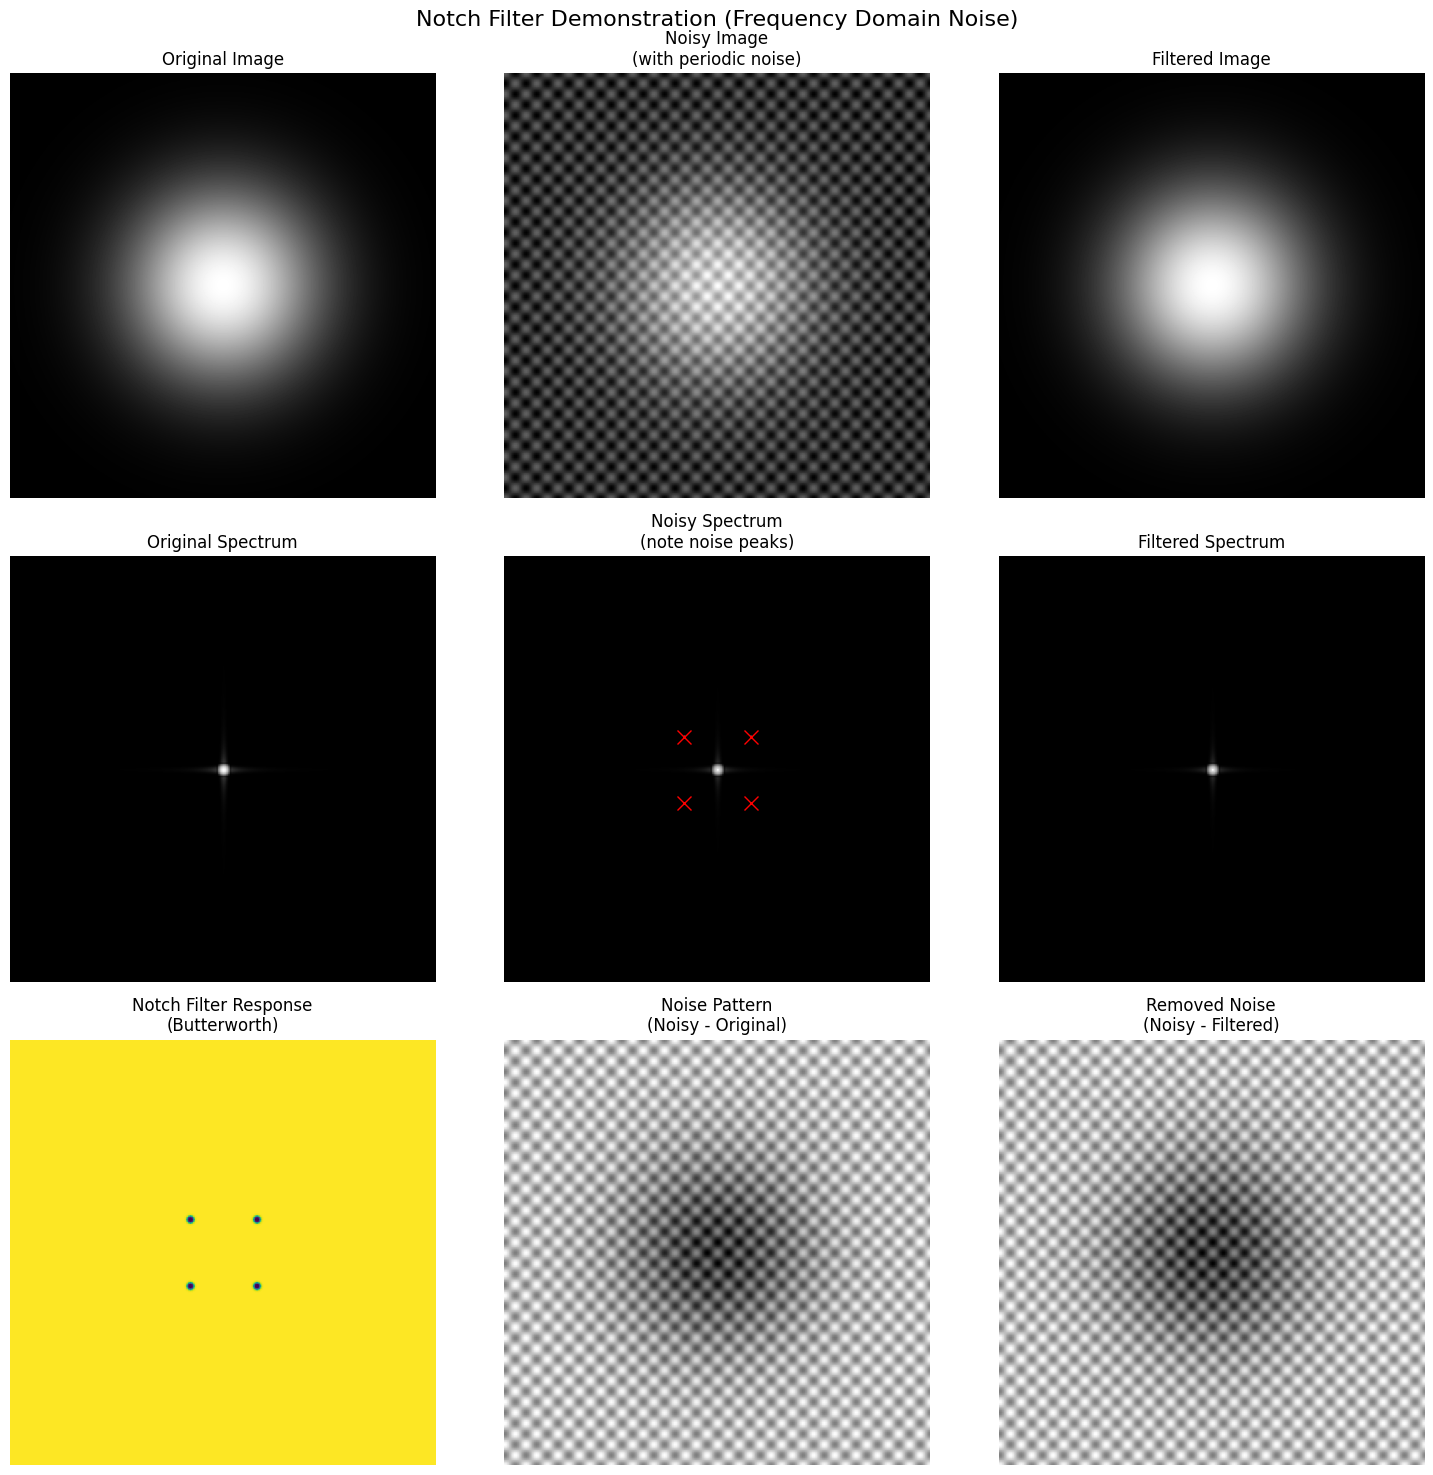


Parameters used:
Noise frequencies at (u,v) coordinates:
(±20, ±20)
Notch filter D₀ = 2
Butterworth filter order n = 4

Noise reduction: 100.0%


In [4]:

def create_demonstration():
    # [Previous code remains the same until the filter function]

    def butterworth_notch_reject(U, V, uk, vk, D0, n=4):
        """Create Butterworth notch filter."""
        H = np.ones_like(U, dtype=float)  # Initialize as float type

        # Distance from each notch point
        for u_k, v_k in [(uk, vk), (-uk, -vk), (uk, -vk), (-uk, vk)]:
            D = np.sqrt((U - u_k)**2 + (V - v_k)**2)
            H *= 1 / (1 + (D0 / (D + 1e-6))**(2*n))

        return H

    # Create base image
    size = 256
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Create original image (a simple Gaussian blob)
    original = np.exp(-(X**2 + Y**2)/20)

    # Create noise in frequency domain
    F_noise = np.zeros((size, size), dtype=complex)
    uk, vk = 20, 20  # Specific frequency coordinates
    center = size // 2
    amplitude = 1.0

    # Place impulses at symmetric locations
    F_noise[center + uk, center + vk] = amplitude  # Top right
    F_noise[center - uk, center - vk] = amplitude  # Bottom left
    F_noise[center + uk, center - vk] = amplitude  # Bottom right
    F_noise[center - uk, center + vk] = amplitude  # Top left

    # Convert to spatial domain
    noise = np.real(np.fft.ifft2(np.fft.ifftshift(F_noise)))
    noise = 0.3 * noise / np.max(np.abs(noise))  # Scale amplitude

    # Add noise to image
    noisy = original + noise

    # Normalize images to [0,1]
    original = (original - original.min()) / (original.max() - original.min())
    noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())

    # Create notch filter
    u = np.arange(-size//2, size//2)
    v = np.arange(-size//2, size//2)
    U, V = np.meshgrid(u, v)

    # Create and apply filter
    D0 = 2  # Small notch width for precise filtering
    H = butterworth_notch_reject(U, V, uk, vk, D0)

    # Apply filter
    F_noisy = np.fft.fftshift(np.fft.fft2(noisy))
    F_filtered = F_noisy * H
    filtered = np.real(np.fft.ifft2(np.fft.ifftshift(F_filtered)))

    # Normalize filtered image
    filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min())

    # Create visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    plt.suptitle('Notch Filter Demonstration (Frequency Domain Noise)', fontsize=16)

    # First row: Spatial domain
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title('Original Image')

    axes[0,1].imshow(noisy, cmap='gray')
    axes[0,1].set_title('Noisy Image\n(with periodic noise)')

    axes[0,2].imshow(filtered, cmap='gray')
    axes[0,2].set_title('Filtered Image')

    # Second row: Frequency domain
    F_original = np.fft.fftshift(np.fft.fft2(original))
    spectrum_original = np.log(np.abs(F_original) + 1)
    axes[1,0].imshow(spectrum_original, cmap='gray')
    axes[1,0].set_title('Original Spectrum')

    spectrum_noisy = np.log(np.abs(F_noisy) + 1)
    axes[1,1].imshow(spectrum_noisy, cmap='gray')
    axes[1,1].set_title('Noisy Spectrum\n(note noise peaks)')

    # Mark noise frequencies
    axes[1,1].plot(center + vk, center + uk, 'rx', markersize=10)
    axes[1,1].plot(center - vk, center - uk, 'rx', markersize=10)
    axes[1,1].plot(center + vk, center - uk, 'rx', markersize=10)
    axes[1,1].plot(center - vk, center + uk, 'rx', markersize=10)

    spectrum_filtered = np.log(np.abs(F_filtered) + 1)
    axes[1,2].imshow(spectrum_filtered, cmap='gray')
    axes[1,2].set_title('Filtered Spectrum')

    # Third row: Filter and differences
    axes[2,0].imshow(H, cmap='viridis')
    axes[2,0].set_title('Notch Filter Response\n(Butterworth)')

    # Show noise pattern
    difference_noise = noisy - original
    axes[2,1].imshow(difference_noise, cmap='gray')
    axes[2,1].set_title('Noise Pattern\n(Noisy - Original)')

    # Show removed noise
    difference_filtered = noisy - filtered
    axes[2,2].imshow(difference_filtered, cmap='gray')
    axes[2,2].set_title('Removed Noise\n(Noisy - Filtered)')

    # Remove axes for cleaner look
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Print parameters used
    print("\nParameters used:")
    print(f"Noise frequencies at (u,v) coordinates:")
    print(f"(±{uk}, ±{vk})")
    print(f"Notch filter D₀ = {D0}")
    print("Butterworth filter order n = 4")

    # Calculate and print improvement metrics
    mse_noise = np.mean((noisy - original)**2)
    mse_filtered = np.mean((filtered - original)**2)
    improvement = (mse_noise - mse_filtered) / mse_noise * 100
    print(f"\nNoise reduction: {improvement:.1f}%")

# Run demonstration
create_demonstration()

## Real case scenarios

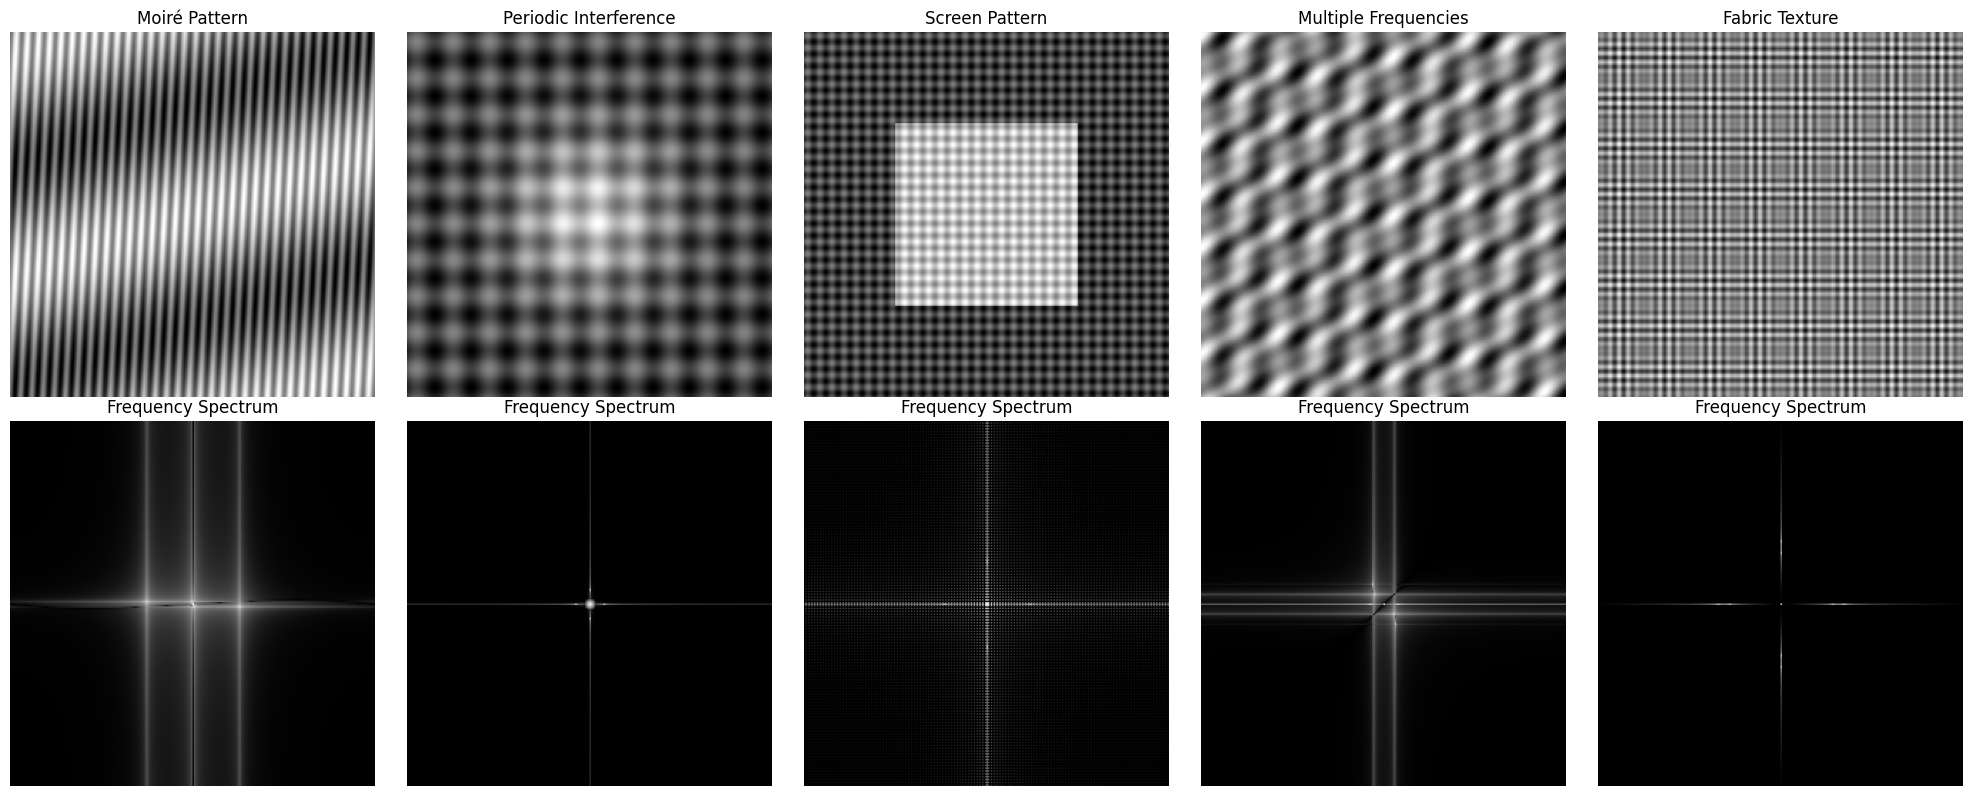

In [5]:
def create_test_images(size=256):
    """Create various test images demonstrating notch filter applications."""
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Dictionary to store all test images
    test_images = {}

    # 1. Moiré Pattern (simulating newspaper print interference)
    freq1, freq2 = 5.0, 5.2  # Slightly different frequencies
    angle1, angle2 = 0, 0.1  # Slightly different angles
    pattern1 = np.sin(freq1 * (X*np.cos(angle1) + Y*np.sin(angle1)))
    pattern2 = np.sin(freq2 * (X*np.cos(angle2) + Y*np.sin(angle2)))
    moire = pattern1 * pattern2
    test_images['Moiré Pattern'] = (moire + 1) / 2  # Normalize to [0,1]

    # 2. Periodic Interference (like electronic interference)
    base_image = np.exp(-(X**2 + Y**2)/20)  # Gaussian blob
    interference = 0.5 * np.sin(2*np.pi*X*0.5) + 0.5 * np.sin(2*np.pi*Y*0.5)
    noisy_image = base_image + 0.5 * interference
    test_images['Periodic Interference'] = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())

    # 3. Screen Pattern (like scanning printed material)
    screen_x = np.sin(2*np.pi*X*1.5)
    screen_y = np.sin(2*np.pi*Y*1.5)
    screen = (screen_x + screen_y) / 2
    # Add some content
    text_region = np.zeros_like(X)
    text_region[size//4:3*size//4, size//4:3*size//4] = 1
    screen_pattern = text_region + 0.5 * screen
    test_images['Screen Pattern'] = (screen_pattern - screen_pattern.min()) / (screen_pattern.max() - screen_pattern.min())

    # 4. Multiple Frequency Interference
    freq_matrix = np.zeros_like(X)
    # Add several sinusoidal patterns at different frequencies and orientations
    for freq, angle, amp in [(3, 0, 0.5), (3, np.pi/4, 0.5), (5, np.pi/3, 0.3)]:
        freq_matrix += amp * np.sin(freq * (X*np.cos(angle) + Y*np.sin(angle)))
    test_images['Multiple Frequencies'] = (freq_matrix - freq_matrix.min()) / (freq_matrix.max() - freq_matrix.min())

    # 5. Fabric Texture (simulating textile patterns)
    fabric_x = np.sin(2*np.pi*X*2) * np.sin(2*np.pi*X*0.2)
    fabric_y = np.sin(2*np.pi*Y*2) * np.sin(2*np.pi*Y*0.2)
    fabric = (fabric_x + fabric_y) / 2
    test_images['Fabric Texture'] = (fabric - fabric.min()) / (fabric.max() - fabric.min())

    return test_images

def display_test_images(test_images):
    """Display all test images with their Fourier spectrums."""
    n_images = len(test_images)
    fig, axes = plt.subplots(2, n_images, figsize=(20, 8))

    for idx, (name, img) in enumerate(test_images.items()):
        # Display original image
        axes[0, idx].imshow(img, cmap='gray')
        axes[0, idx].set_title(f'{name}')
        axes[0, idx].axis('off')

        # Display frequency spectrum
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(np.abs(fshift) + 1)
        axes[1, idx].imshow(magnitude_spectrum, cmap='gray')
        axes[1, idx].set_title('Frequency Spectrum')
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

# Create and display test images
test_images = create_test_images(256)
display_test_images(test_images)



In [6]:
def apply_notch_filter_demo(image_name='Moiré Pattern', uk=10, vk=10, D0=5, n_butterworth=4):
    """Apply notch filters to a specific test image and show results."""
    img = test_images[image_name]

    # Get Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Create frequency grid
    rows, cols = img.shape
    x = np.arange(-cols//2, cols//2)
    y = np.arange(-rows//2, rows//2)
    X, Y = np.meshgrid(x, y)

    # Create and apply filters
    ideal = ideal_notch_reject(X, Y, uk, vk, D0)
    butterworth = butterworth_notch_reject(X, Y, uk, vk, D0, n_butterworth)
    gaussian = gaussian_notch_reject(X, Y, uk, vk, D0)

    # Apply filters
    filtered_ideal = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * ideal)))
    filtered_butter = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * butterworth)))
    filtered_gaussian = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * gaussian)))

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Original
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(np.log(np.abs(fshift) + 1), cmap='gray')
    axes[1,0].set_title('Original Spectrum')

    # Ideal
    axes[0,1].imshow(filtered_ideal, cmap='gray')
    axes[0,1].set_title('Ideal Notch Filtered')
    axes[1,1].imshow(np.log(np.abs(fshift * ideal) + 1), cmap='gray')
    axes[1,1].set_title('Ideal Notch Spectrum')

    # Butterworth
    axes[0,2].imshow(filtered_butter, cmap='gray')
    axes[0,2].set_title('Butterworth Notch Filtered')
    axes[1,2].imshow(np.log(np.abs(fshift * butterworth) + 1), cmap='gray')
    axes[1,2].set_title('Butterworth Notch Spectrum')

    # Gaussian
    axes[0,3].imshow(filtered_gaussian, cmap='gray')
    axes[0,3].set_title('Gaussian Notch Filtered')
    axes[1,3].imshow(np.log(np.abs(fshift * gaussian) + 1), cmap='gray')
    axes[1,3].set_title('Gaussian Notch Spectrum')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [7]:
# Create interactive demonstration
interact(
    apply_notch_filter_demo,
    image_name=widgets.Dropdown(
        options=list(test_images.keys()),
        value='Moiré Pattern',
        description='Image:'
    ),
    uk=widgets.IntSlider(
        value=10,
        min=-50,
        max=50,
        step=1,
        description='uk:'
    ),
    vk=widgets.IntSlider(
        value=10,
        min=-50,
        max=50,
        step=1,
        description='vk:'
    ),
    D0=widgets.IntSlider(
        value=5,
        min=1,
        max=20,
        step=1,
        description='D₀:'
    ),
    n_butterworth=widgets.IntSlider(
        value=4,
        min=1,
        max=10,
        step=1,
        description='n:'
    )
)

interactive(children=(Dropdown(description='Image:', options=('Moiré Pattern', 'Periodic Interference', 'Scree…

<function __main__.apply_notch_filter_demo(image_name='Moiré Pattern', uk=10, vk=10, D0=5, n_butterworth=4)>